# Econometrics of Marketing 
## Prediction of Airbnb prices

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy.spatial import distance
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as py

## Import the two datasets 

In [100]:
data = pd.read_csv("/Users/mariannehabert/Documents/M2_Stat_Eco/S1/Econometric_Marketing/ProjectAirbnb/train_airbnb.csv", index_col="id")
test = pd.read_csv("/Users/mariannehabert/Documents/M2_Stat_Eco/S1/Econometric_Marketing/ProjectAirbnb/test_airbnb.csv", index_col="id")
data.head(3)

,name,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_since,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,geolocation,features,geopoint_announce,department
id,,,,,,,,,,,,,,,,,,,,,
10534791,Appartement 2P pour 4 pers. BERCY,Cet appartement est idéalement situé à 10 minu...,Le quartier est animé sans être étouffant. Il ...,NaN,Lignes de métro 6 et 8 à moins de 3 minutes. ...,Vous aurez accès à l'ensemble du logement.,NaN,NaN,22523453,2014-10-14T00:00:00.000Z,...,7.0,8.0,10.0,8.0,strict,0.16,"48.8410132928,2.39288035231",Host Has Profile Pic,POINT(2.3928803523142053 48.841013292835235),Paris
16001259,"Cosy 2 pièces in Paris 12ème, Porte Dorée","Mon logement est proche du bois de Vincennes, ...",NaN,NaN,NaN,NaN,NaN,NaN,37202116,2015-07-01T00:00:00.000Z,...,NaN,NaN,NaN,NaN,flexible,NaN,"48.8408064183,2.40824414207",Host Has Profile Pic,POINT(2.4082441420748024 48.84080641832087),Paris
17763072,Charmant Studio Paris 11/12ème,Un studio cosy qui sera votre nid douillet lor...,"Le quartier est agréable, vivant et convivial ...",La TV est à l'ancienne donc les aficionados de...,Il est très bien situé puisque proche des stat...,À l'ensemble des fonctionnalités de l'appartem...,"Si mon emploi du temps le permet! Sinon, les i...",Je compte sur vous pour prendre soin de ce coc...,73025491,2016-05-20T00:00:00.000Z,...,10.0,10.0,9.0,8.0,moderate,2.00,"48.8482384171,2.38914645391","Host Has Profile Pic,Host Identity Verified",POINT(2.389146453908913 48.84823841713855),Paris


## Delete the Nan 

In [101]:
data = data[-pd.isnull(data['price'])]
data = data[-pd.isnull(data['accommodates'])]
data = data[-pd.isnull(data['bathrooms'])]
data = data[-pd.isnull(data['bedrooms'])]
data = data[-pd.isnull(data['beds'])]
data = data[-pd.isnull(data['host_listings_count'])]

## The aim here is to count the number of amenities per flat and the number of host verifications

In [102]:
new = data["amenities"].str.split(",", n = 49, expand = True)
new1 = test["amenities"].str.split(",", n = 49, expand = True)

In [103]:
data["nb_amenities"]=new.count(axis=1)
test["nb_amenities"]=new1.count(axis=1)

In [104]:
verif = data["host_verifications"].str.split(",", n = 49, expand = True)
verif1 = test["host_verifications"].str.split(",", n = 49, expand = True)

In [105]:
data['nb_host_verifications']=verif.count(axis=1)
test['nb_host_verifications']=verif1.count(axis=1)

##  Create categorical variable for the minimum of nights

In [106]:
def func(x):
    if 0 < x <= 3:
        return 'short stay'
    elif 3 < x <= 10:
        return 'medium stay'
    elif 10 <x:
        return 'long stay'

data['minimum_nights'] = data['minimum_nights'].apply(func)
test['minimum_nights'] = test['minimum_nights'].apply(func)

## Create Dummies 

In [107]:
data_minimum = pd.get_dummies(data['minimum_nights'])
data_minimum_test = pd.get_dummies(test['minimum_nights'])

In [108]:
data_room = pd.get_dummies(data['room_type'])
data_room_test = pd.get_dummies(test['room_type'])

In [109]:
data_property = pd.get_dummies(data['property_type'])
data_property_test = pd.get_dummies(test['property_type'])

In [110]:
data_secu = pd.get_dummies(data['security_deposit'])
data_secu_test = pd.get_dummies(test['security_deposit'])

In [111]:
data_secu= data_secu.rename(columns={'0_no_deposit': 'no_deposit','1_]0-200]' : '1_0_200','2_]200-400]' : '2_200_400','03_[400-++[':'3_400'})
data_secu_test= data_secu_test.rename(columns={'0_no_deposit': 'no_deposit','1_]0-200]' : '1_0_200','2_]200-400]' : '2_200_400','03_[400-++[':'3_400'})

In [112]:
data_cleaning = pd.get_dummies(data['cleaning_fee'])
data_cleaning_test = pd.get_dummies(test['cleaning_fee'])

In [113]:
data_cleaning= data_cleaning.rename(columns={'1_]0-30]' : '1_0_30','2_]30-60]' : '2_30_60','03_[60-++[':'3_60'})
data_cleaning_test= data_cleaning_test.rename(columns={'1_]0-30]' : '1_0_30','2_]30-60]' : '2_30_60','03_[60-++[':'3_60'})

In [114]:
data=pd.concat([data,data_minimum,data_room,data_property,data_secu,data_cleaning],axis=1)
test=pd.concat([test,data_minimum_test,data_room_test,data_property_test,data_secu_test,data_cleaning_test],axis=1)

### Drop variables which are useless
#### We will keep only the variables that had been cleaned and those which are numerical
#### The study of the other qualitative variables have been made before but didn't give good results

In [115]:
data_clean=data.drop(['name','description','neighborhood_overview','notes','transit','calendar_updated','access',
                      'property_type','room_type','interaction','cleaning_fee','house_rules','host_since','host_response_time',
                      'neighbourhood_cleansed','country','city','country','bed_type','amenities','geolocation','features',
                      'geopoint_announce','department','minimum_nights','security_deposit','first_review','last_review',
                      'host_verifications','cancellation_policy'], axis=1)
test_clean=test.drop(['name','description','neighborhood_overview','notes','transit','calendar_updated','access',
                      'property_type','room_type','interaction','cleaning_fee','house_rules','host_since','host_response_time',
                      'neighbourhood_cleansed','country','city','country','bed_type','amenities','geolocation','features',
                      'geopoint_announce','department','minimum_nights','security_deposit','first_review','last_review',
                      'host_verifications','cancellation_policy'], axis=1)

In [116]:
list(test_clean)

['host_id',
 'host_seniority',
 'host_response_rate',
 'host_listings_count',
 'zipcode',
 'latitude_airbnb',
 'longitude_airbnb',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'extra_people',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'nb_amenities',
 'nb_host_verifications',
 'long stay',
 'medium stay',
 'short stay',
 'Entire home/apt',
 'Private room',
 'Shared room',
 'Apartment',
 'Bed & Breakfast',
 'Boat',
 'Boutique hotel',
 'Cabin',
 'Cave',
 'Condominium',
 'Dorm',
 'Guesthouse',
 'Hostel',
 'House',
 'Loft',
 'Other',
 'Serviced apartment',
 'Timeshare',
 'Townhouse',
 'Villa',
 '3_400',
 'no_deposit',
 '1_0_200',
 '2_200_400',
 '3_60',
 '0_no_deposit',
 '1_

In [117]:
test_clean.dtypes

host_id                          int64
host_seniority                 float64
host_response_rate             float64
host_listings_count            float64
zipcode                          int64
latitude_airbnb                float64
longitude_airbnb               float64
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
guests_included                  int64
extra_people                     int64
maximum_nights                   int64
availability_30                  int64
availability_60                  int64
availability_90                  int64
availability_365                 int64
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value      

## Here, I keep the columns that i want to include in my regression and I split both datasets with price and other columns

In [118]:
cols = ['host_id',
 'host_response_rate',
 'host_listings_count',
 'zipcode',
 'latitude_airbnb',
 'longitude_airbnb',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'extra_people',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'nb_amenities',
 'nb_host_verifications',
 'long stay',
 'medium stay',
 'short stay',
 'Entire home/apt',
 'Private room',
 'Shared room',
 '3_400',
 'no_deposit',
 '1_0_200',
 '2_200_400',
 '3_60',
 '0_no_deposit',
 '1_0_30',
 '2_30_60']
features=data_clean[cols]
label=data_clean['price']

#Split the data
X_train, X_test, y_train, y_test=train_test_split(features, label, test_size=0.1)

X_sub=test_clean[cols]

### I tried different method to predict the price : K-nearest-neighboor, Random Forest... but the Extreme Gradient Boosting is the one that gives me the best results

MSE: 1453.026471
RMSE: 38.118584


<Container object of 42 artists>

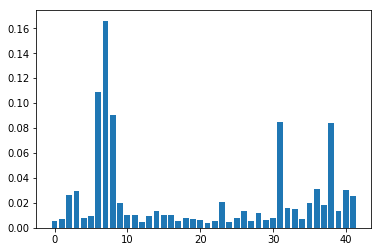

In [123]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


xg_price = xgb.XGBRegressor(objective = "reg:squarederror", colsample_bytree=0.4, learning_rate=0.1, 
                           max_depth=8, n_estimators=500)
xg_price.fit(X_train, y_train)

preds = xg_price.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))
py.bar(range(len(xg_price.feature_importances_)), xg_price.feature_importances_)
#py.show()

In [124]:
preds = xg_price.predict(X_sub)

In [125]:
preds=pd.DataFrame(preds)
preds.index=test_clean.index
preds.columns = ['Predicted']
preds.rename(index={'id':'Id'})

,Predicted
id,
7589843,68.292816
2742013,92.971306
11488354,54.656879
3392641,118.111588
1548734,91.525856
13705340,59.446457
11080877,47.511768
4115735,135.212418
9267360,106.437973


In [75]:
preds.to_csv(r'/Users/mariannehabert/Documents/M2_Stat_Eco/S1/Econometric_Marketing/ProjectAirbnb/Submission_xgboost1.csv')